## Test of Modis Loader

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [31]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from util import TwoCropTransform, AverageMeter
from ulmo import io as ulmo_io
import json
import h5py
import numpy as np
import torch
import skimage
import skimage.transform

In [3]:
class Params():
    """Class that loads hyperparameters from a json file.
    Example:
    ```
    params = Params(json_path)
    print(params.learning_rate)
    params.learning_rate = 0.5  # change the value of learning_rate in params
    ```
    This module comes from:
    https://github.com/cs230-stanford/cs230-code-examples/blob/master/pytorch/vision/utils.py
    """

    def __init__(self, json_path):
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def save(self, json_path):
        with open(json_path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)
            
    def update(self, json_path):
        """Loads parameters from json file"""
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    @property
    def dict(self):
        """Gives dict-like access to Params instance by `params.dict['learning_rate']"""
        return self.__dict__

In [4]:
def option_preprocess(opt: Params):
    """
    Args:
        opt: (Params) json used to store the training hyper-parameters
    Returns:
        opt: (Params) processed opt
    """

    # check if dataset is path that passed required arguments
    if opt.modis_data == True:
        assert opt.data_folder is not None
        
    # set the path of the training data folder
    if opt.data_folder is None:
        opt.data_folder = './experimens/datasets/'
    opt.model_path = f'./experiments/{opt.method}/{opt.dataset}_models'
    opt.tb_path = f'./experiments/{opt.method}/{opt.dataset}_tensorboard'

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = list([])
    for it in iterations:
        opt.lr_decay_epochs.append(int(it))

    opt.model_name = '{}_{}_{}_lr_{}_decay_{}_bsz_{}_temp_{}_trial_{}'.\
        format(opt.method, opt.dataset, opt.model, opt.learning_rate,
               opt.weight_decay, opt.batch_size, opt.temp, opt.trial)

    if opt.cosine:
        opt.model_name = '{}_cosine'.format(opt.model_name)

    # warm-up for large-batch training,
    if opt.batch_size > 256:
        opt.warm = True
    if opt.warm:
        opt.model_name = '{}_warm'.format(opt.model_name)
        opt.warmup_from = 0.01
        opt.warm_epochs = 10
        if opt.cosine:
            eta_min = opt.learning_rate * (opt.lr_decay_rate ** 3)
            opt.warmup_to = eta_min + (opt.learning_rate - eta_min) * (
                    1 + math.cos(math.pi * opt.warm_epochs / opt.epochs)) / 2
        else:
            opt.warmup_to = opt.learning_rate

    opt.tb_folder = os.path.join(opt.tb_path, opt.model_name)
    if not os.path.isdir(opt.tb_folder):
        os.makedirs(opt.tb_folder)

    opt.save_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)

    return opt

In [5]:
class RandomRotate:
    def __call__(self, image):
    # print("RR", image.shape, image.dtype)
        return (skimage.transform.rotate(image, np.float32(360*np.random.rand(1)))).astype(np.float32)
    
class JitterCrop:
    def __init__(self, crop_dim=32, rescale=2, jitter_lim=0):
        self.crop_dim = crop_dim
        self.offset = self.crop_dim//2
        self.jitter_lim = jitter_lim
        self.rescale = rescale
        
    def __call__(self, image):
        center_x = image.shape[0]//2
        center_y = image.shape[0]//2
        if self.jitter_lim:
            center_x += int(np.random.randint(-self.jitter_lim, self.jitter_lim+1, 1))
            center_y += int(np.random.randint(-self.jitter_lim, self.jitter_lim+1, 1))

        image_cropped = image[(center_x-self.offset):(center_x+self.offset), (center_y-self.offset):(center_y+self.offset), 0]
        image = np.expand_dims(skimage.transform.rescale(image_cropped, self.rescale), axis=-1)
        image = np.repeat(image, 3, axis=-1)
        
        return image
    
class GaussianNoise:
    def __init__(self, instrument_noise=(0, 0.1)):
        self.noise_mean = instrument_noise[0]
        self.noise_std = instrument_noise[1]

    def __call__(self, image):
        noise_shape = image.shape
        noise = np.random.normal(self.noise_mean, self.noise_std, size=noise_shape)
        image += noise

        return image

In [17]:
class ModisDataset(Dataset):
    def __init__(self, data_path, transform, from_s3=False):
        self.data_path = data_path
        self.transform = transform
        self.from_s3 = from_s3

    def _open_file(self):
        if self.from_s3:
            self.files = load_data_h5(self.data_path)
        else:
            with h5py.File(self.data_path, 'r') as file:
                self.files = file['train'][:]

    def __len__(self):
        self._open_file()
        num_samples = self.files.shape[0]
        return num_samples

    def __getitem__(self, global_idx):
        self._open_file()
        image = self.files[global_idx]
        image_transposed = np.transpose(image, (1, 2, 0))
        image_transformed = self.transform(image_transposed)
        
        return image_transformed

In [7]:
def modis_loader(opt):
    transforms_compose = transforms.Compose([RandomRotate(),
                                             JitterCrop(),
                                             GaussianNoise(),
                                             transforms.ToTensor()])
    modis_path = opt.data_folder
    from_s3 = (modis_path.split(':')[0] == 's3')
    modis_dataset = ModisDataset(modis_path, transform=TwoCropTransform(transforms_compose), from_s3=from_s3)
    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
                    modis_dataset, batch_size=opt.batch_size, shuffle=(train_sampler is None),
                    num_workers=opt.num_workers, pin_memory=False, sampler=train_sampler)
    
    return train_loader

In [8]:
def load_data_h5(data_path):
    """
    Module used to load the data set with h5 file
    """
    data_bytes = ulmo_io.load_to_bytes(data_path)
    with h5py.File(data_bytes, 'r') as file:
        data = file['train'][:]
        
    return data

### Prepare the dataloader

In [9]:
opt_path = './experiments/base_modis_model/opts.json'

In [10]:
opt = Params(opt_path)

In [25]:
opt.num_workers = 0

In [26]:
train_loader = modis_loader(opt)

### Have a look at the images batch

In [42]:
from ulmo import plotting

In [43]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
test_batch = iter(train_loader).next()

In [36]:
imgs_batch_1, imgs_batch_2 = test_batch

In [47]:
imgs_batch_1.shape

torch.Size([64, 3, 64, 64])

-----------------------------------------------------------

### Show the images in the batch
* random rotation;
* random crop (1/2 * 1/2);
* Gaussian noise (0, 0.1);

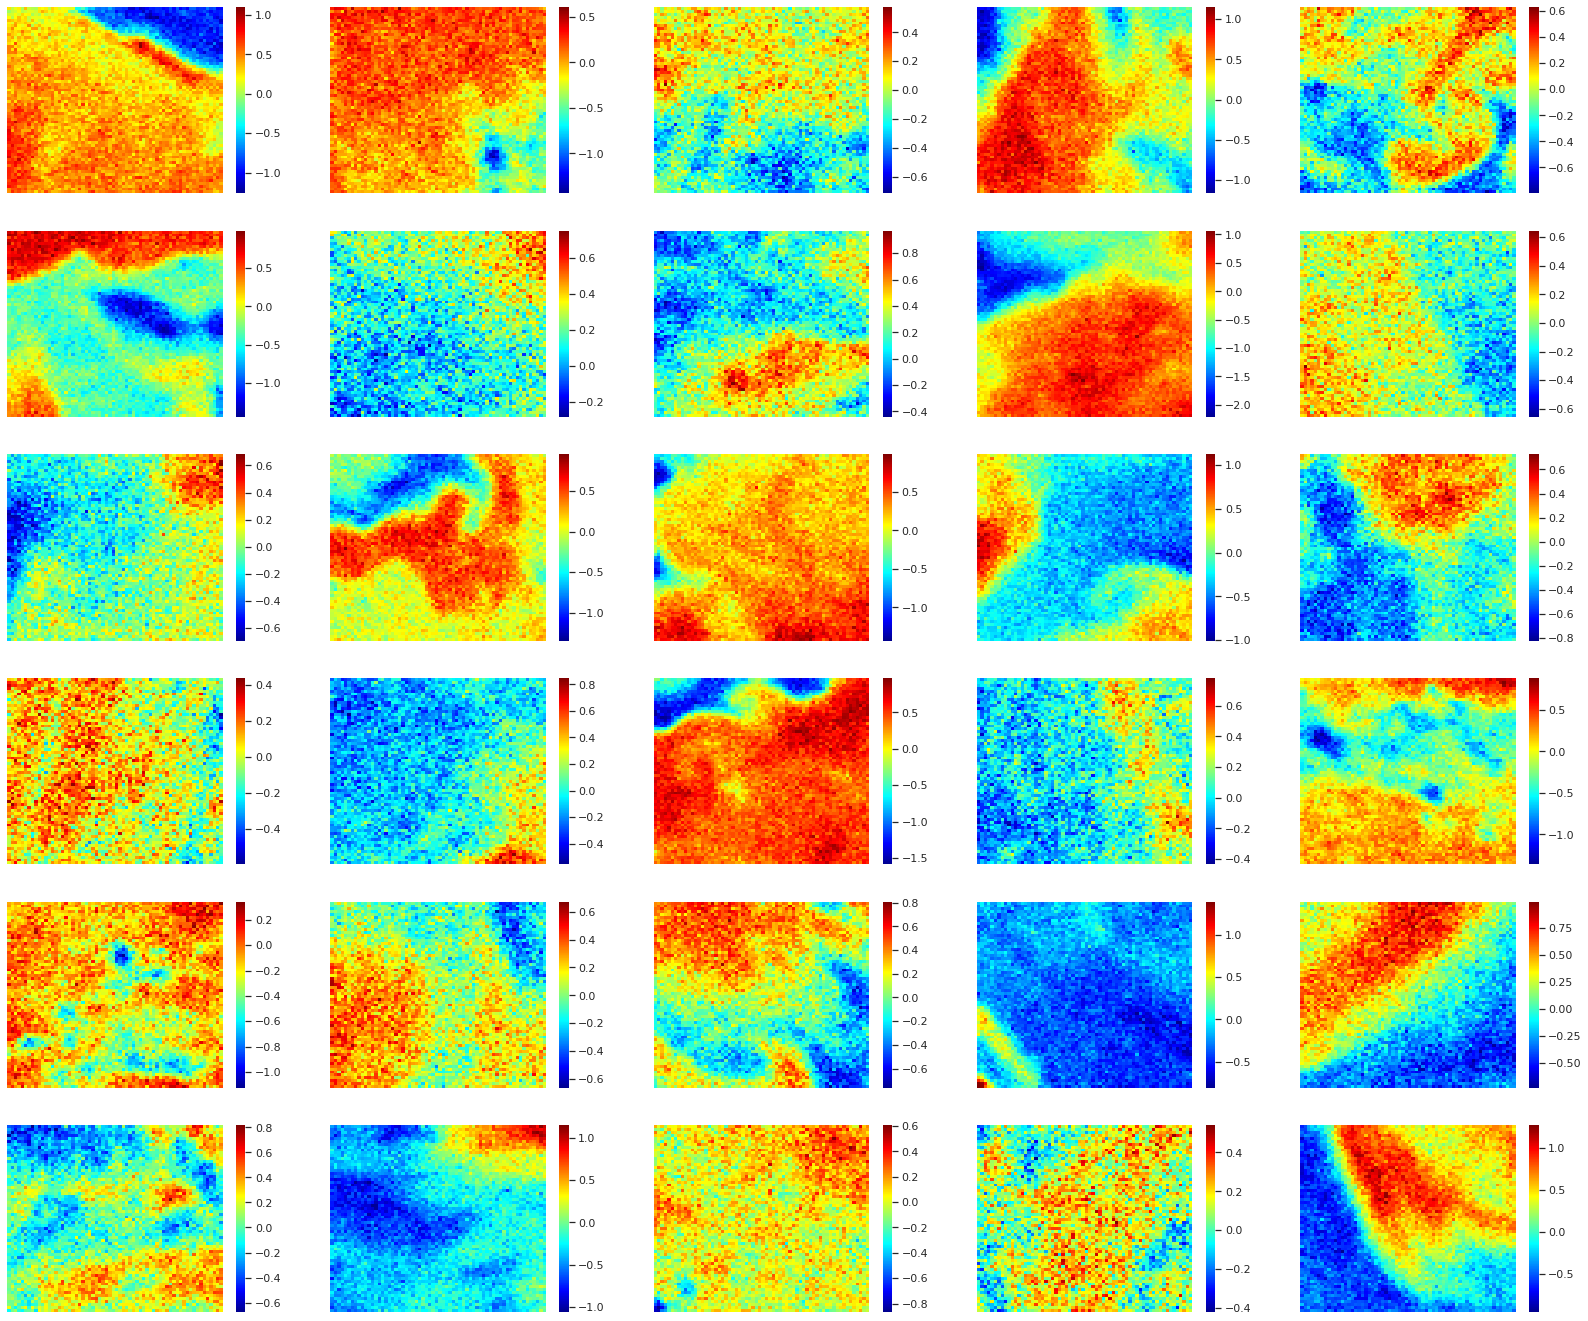

In [44]:
plt.figure(figsize=(28, 24))
for i in range(30):
    plt.subplot(6, 5, i+1)
    sns.heatmap(imgs_batch_1[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)

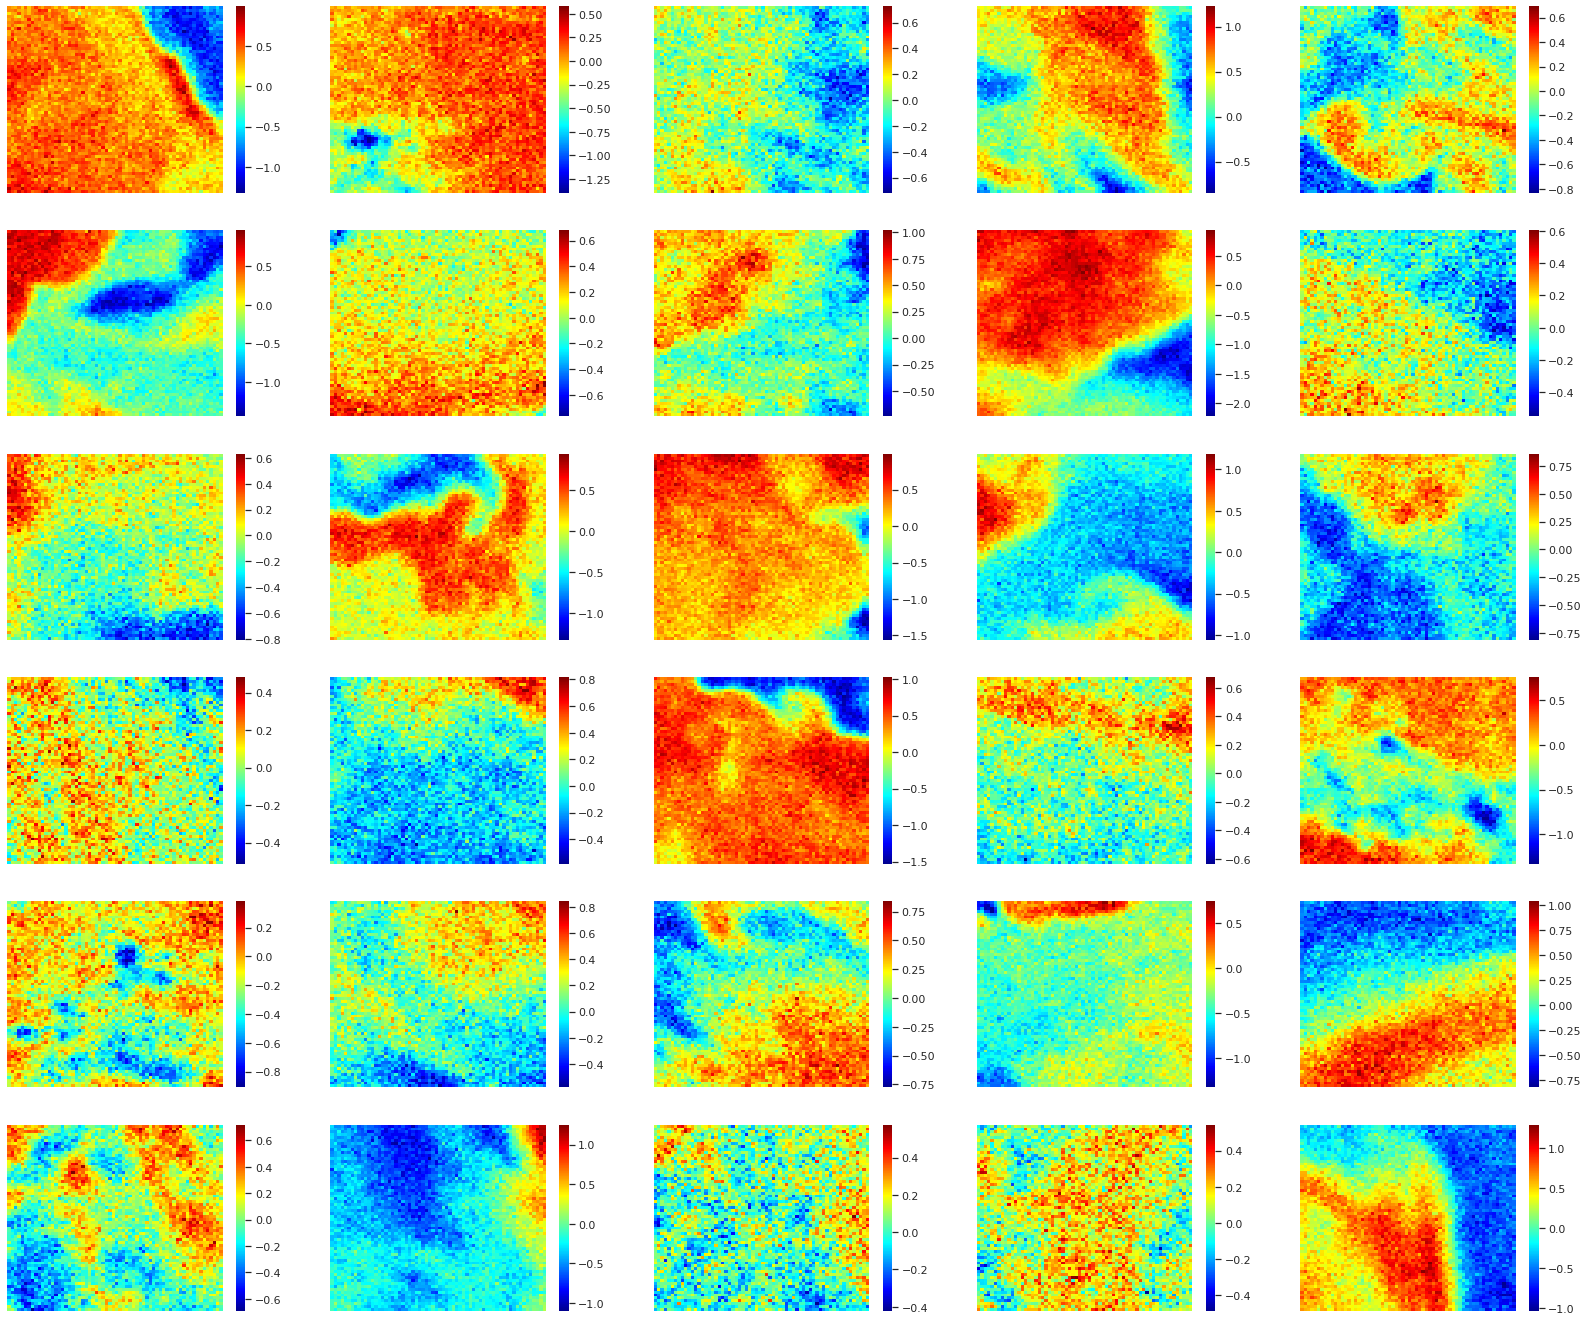

In [45]:
plt.figure(figsize=(28, 24))
for i in range(30):
    plt.subplot(6, 5, i+1)
    sns.heatmap(imgs_batch_2[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)

-------------------------------------------------------

### Show the images in the batch

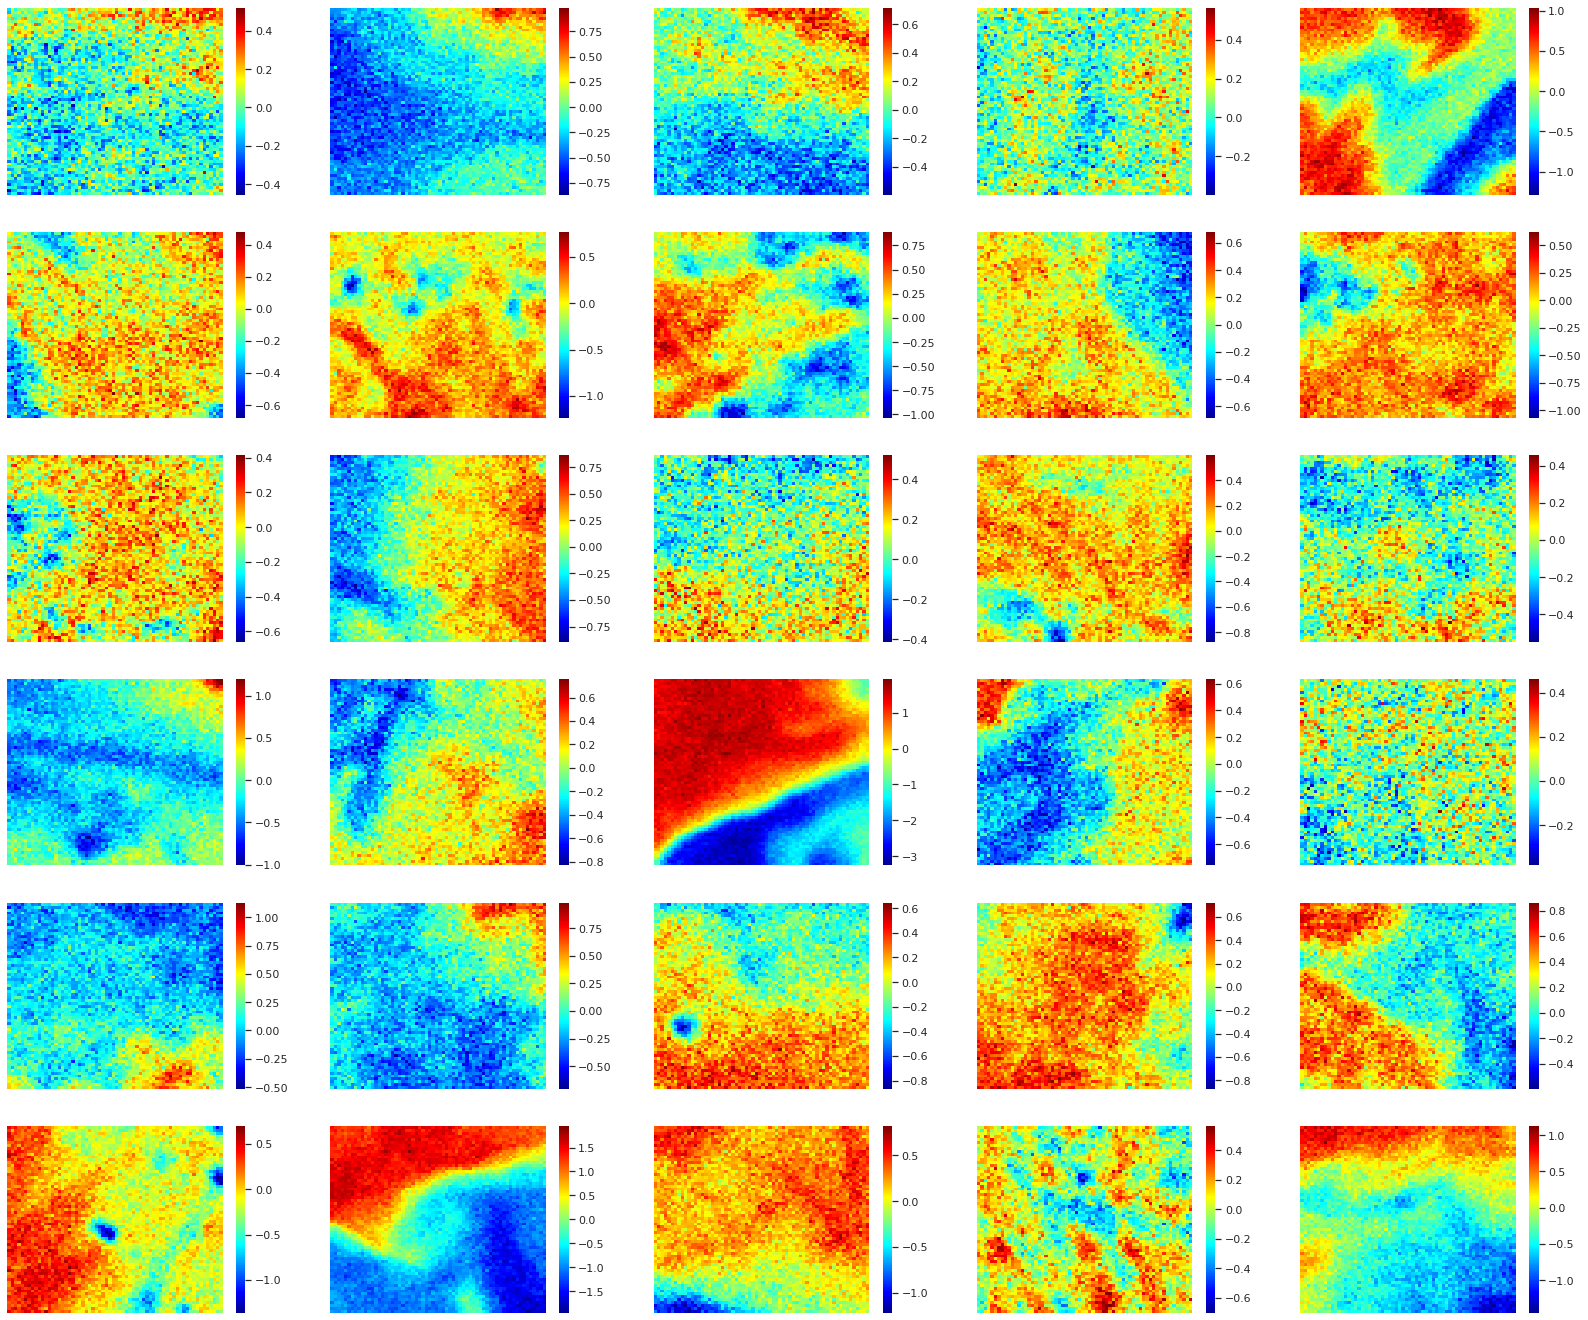

In [48]:
plt.figure(figsize=(28, 24))
for i in range(30, 60):
    plt.subplot(6, 5, i-30+1)
    sns.heatmap(imgs_batch_1[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)

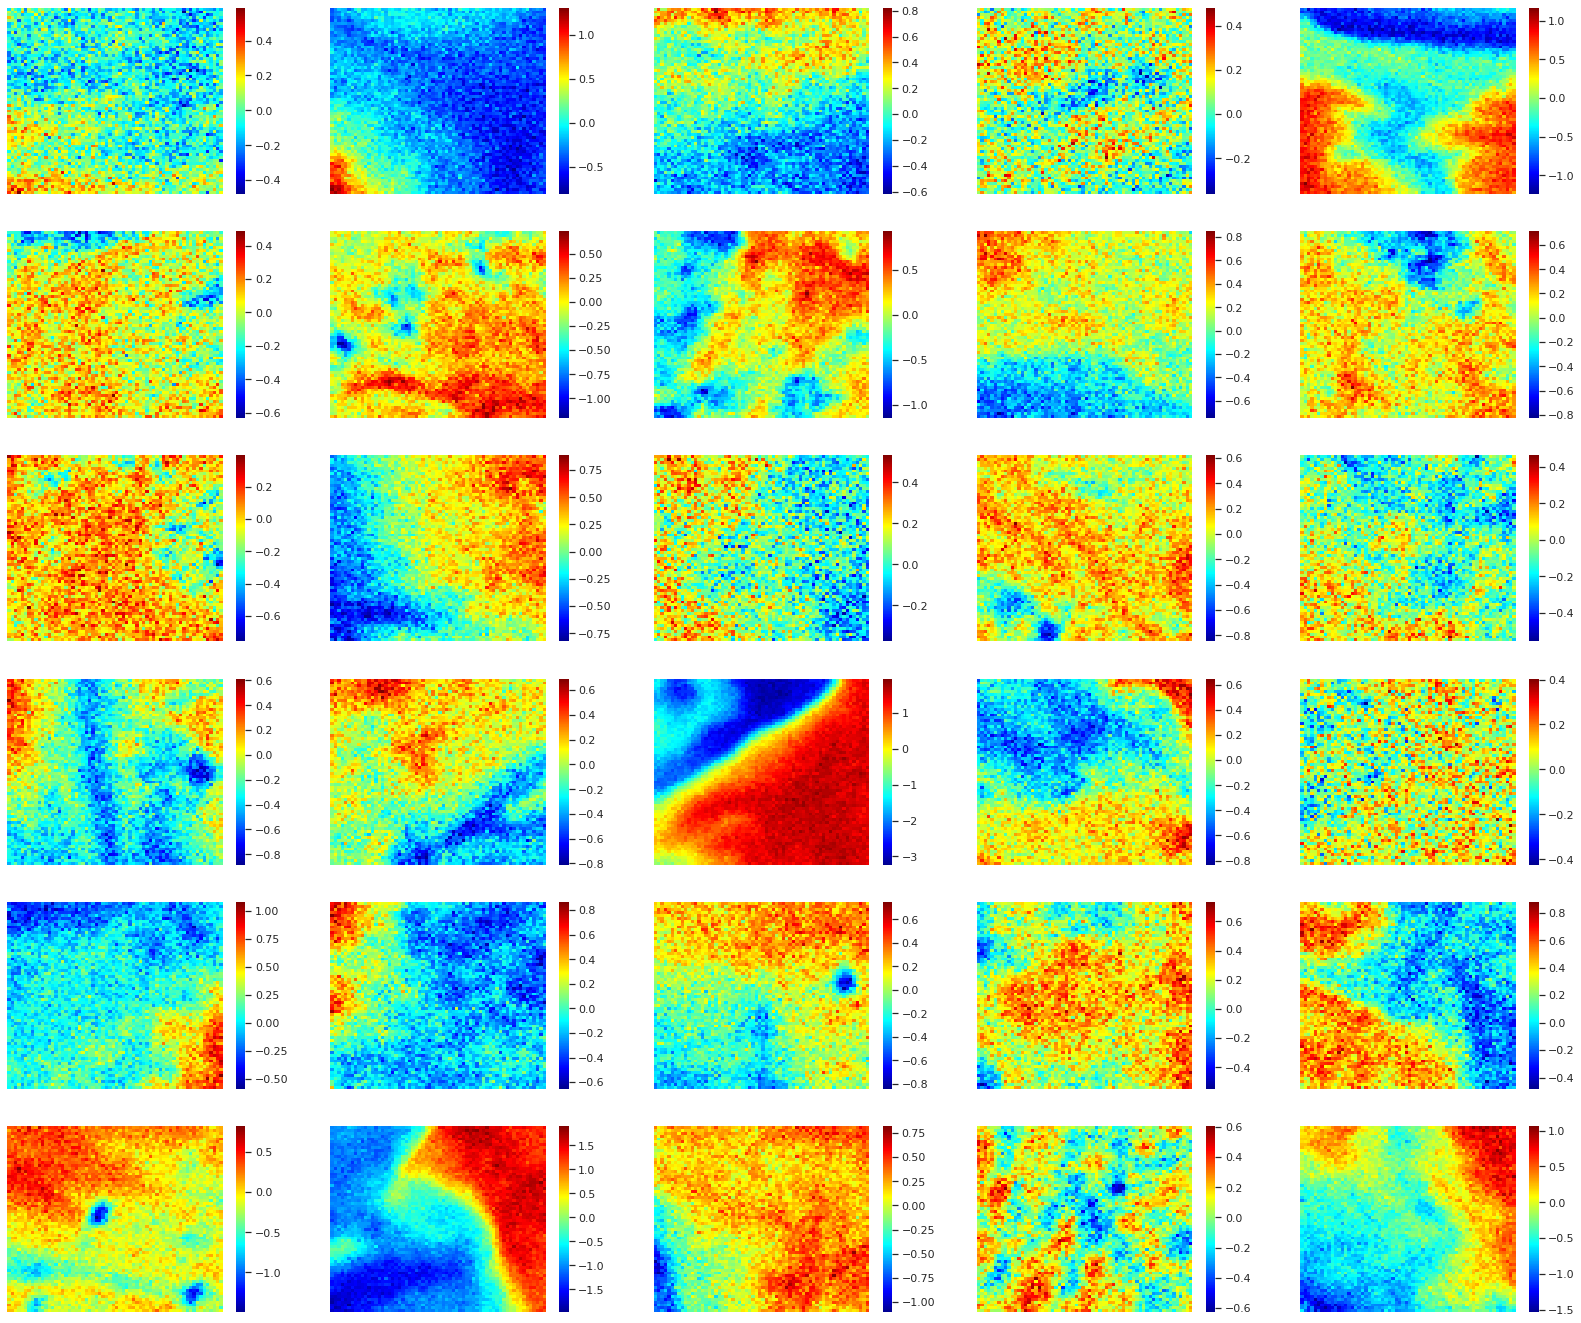

In [49]:
plt.figure(figsize=(28, 24))
for i in range(30, 60):
    plt.subplot(6, 5, i-30+1)
    sns.heatmap(imgs_batch_2[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)